In [3]:
import numpy as np
import os
import sys
sys.path.append('../')
import mlx as ml 
import warnings
import operator
import pickle
import glob
import pylab as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
DEBUG=False

In [32]:
def dictprod(dict_,a=1.0):
    '''
        given a dict of probability distributions 
        represented as such: {'key1': val1, ... ,'keyn':valn}
        multiply all values with the second argument `a`
    '''
    return {key:value*a for (key,value) in dict_.iteritems()}
 
def normalizedict(dict_):
    '''
        given a dict represented as such: {'key1': val1, ... ,'keyn':valn}
        scale all values such that they sum to 1.0    
    '''
    s=0.0
    for key in dict_.keys():
        s=s+dict_[key]
    return {key:(value/s) for (key,value) in dict_.iteritems()}

def mergedistributions(dist_):
    '''
        given a dict of dicts, each represented as such: {'key1': val1, ... ,'keyn':valn}
        we retun a combined dict, where values corresponding  to key1 is the average over 
        all component dicts
    '''
    num=len(dist_.keys())
    key_list=[]
    for key in dist_.keys():
        key_list=np.append(key_list,dist_[key].keys())
        
    D={}
    for key in key_list:
        D[key]=0.0
        
    for count in dist_.keys():
        for key_ in dist_[count].keys():
            if key_ in dist_[count]:
                D[key_]=D[key_]+dist_[count][key_]
    return {key:value/(num+0.0) for (key,value) in D.iteritems() }

def getMergedDistribution(tree,cond={}):
    '''
        get distribution over keys given particular
        constriants (cond) on the decision tree
        
        Arguments:
        
        tree: decision tree returned by mlx.py
        cond: conditions that specify constraints
              on the decision tree
        
    '''
    node_id_map={feature_name:np.array([], dtype=int) for (i,feature_name) in tree.feature.iteritems()}
    for (i,feature_name) in tree.feature.iteritems():
        node_id_map[feature_name]=np.append(node_id_map[feature_name],int(i))
    
    if DEBUG:
        print(node_id_map)
    #propagate to find current nodes
    children={i:set() for i in cond.keys()}
    for feature_name in cond.keys():
        for node_id in tree.feature:
            if tree.feature[node_id] == feature_name:
                children[feature_name]=children[feature_name].union(tree.children[node_id])
    if DEBUG:
        print(children)

    current_active_nodes=np.array([],int)
    for feature_name in cond.keys():
        for child in children[feature_name]:
            for parent in node_id_map[feature_name]:
                if (parent,child) in tree.edge_cond_:
                    for edge_var in cond[feature_name]:
                        if edge_var in tree.edge_cond_[(parent,child)]:
                            if DEBUG:
                                print(parent,child,"::",tree.edge_cond_[(parent,child)])
                            current_active_nodes=np.append(current_active_nodes,child)
    
    S=0.0
    if current_active_nodes.size == 0:
        current_active_nodes=np.array([1],int)
    for i in current_active_nodes:
        S=S+tree.num_pass_[i]
        
    indexed_dist={i:dictprod(tree.class_pred_[i],tree.num_pass_[i]/S) for i in current_active_nodes}
    dist_=normalizedict(mergedistributions(indexed_dist))
        
    if DEBUG:
        print(children)
        print(current_active_nodes)
        print("ID",indexed_dist)
        print("MD",mergedistributions(indexed_dist))
        print("ND",normalizedict(mergedistributions(indexed_dist)))
        
    return dist_  
    
def sampleTree(tree,cond={},sample='mle',DIST=False,NUMSAMPLE=10):
    '''
        draw sample from decision tree
        specified in the format that 
        mlx.py returns
        
        Arguments:
        
        1. cond: dict of the format {'name': value, 'name1': value1,...}
                 specifies the constraints on the decision tree.
                 example: {'RBM34':'C','SOX2': 'A'}
        
        Note--> we can use arbitrary cond argument, irrespective of if the
        names are in the decision tree at all or not. Also, we can use 
        an empty cond dict, which corresponds to the unconstrained tree.
        In all these cases, it makes sense to ask what is the distribution on the 
        keys that the decision tree outputs, and we attempt to compute that.
        
        2. sample: 'mle'|'random' 
                   if 'mle' then return the value with maximum probability.
                   if 'random' then makes random choice NUMSAMPLE times 
                   and returns the result.
        
        3. DIST: TRUE|FALSE
                 if TRUE returns the distribution from the tree 
                 after applying the constraints
    '''
    dist_=getMergedDistribution(tree,cond=cond)
    if sample is 'mle':
        sample=max(dist_.iteritems(), key=operator.itemgetter(1))[0]
    if sample is 'random':
        probs = dist_.values()
        keys =  dist_.keys()

        sample = np.random.choice(keys,NUMSAMPLE, replace=True, p=probs)
    if DIST:
        return sample,dist_
    return sample

def getFmap(PATH_TO_TREES):
    F={}
    TREE={}
    TREES=glob.glob(PATH_TO_TREES)
    for filename in tqdm(TREES):
        with open(filename,'rb') as f:
            TR = pickle.load(f)
        f.close()
        index=os.path.splitext(os.path.basename(filename))[0].split('_')[-1]
        #print index
        F[index]=[]
        TREE[index]=TR
        for key,value in TR.feature.iteritems():
            if not TR.TREE_LEAF[key]:
                F[index]=np.append(F[index],value)
    return F,TREE

In [22]:
PATH_TO_TREES='../../cchf/cchfl_trees/*pkl'
gn=pd.read_csv('../../cchf/cchfl_test.csv')
seq=gn.loc[0]

In [23]:
TREENAMES=glob.glob(PATH_TO_TREES)
index=100
with open(TREENAMES[index],'rb') as f:
    TR = pickle.load(f)

print TREES[index]
print TR.feature
print TR.edge_cond_
print TR.class_pred_

../../cchf/cchfl_trees/75_cchfl_P668.pkl
{1: 'P1955', 2: '2', 3: 'P2350', 4: '4', 5: '5'}
{(1, 2): ['A'], (1, 3): ['C', 'T', 'G'], (3, 4): ['A', 'C', 'G'], (3, 5): ['T']}
{1: {'A': 2.0, 'C': 36.0, 'T': 3.0, 'G': 30.0}, 2: {'A': 0.0, 'C': 0.0, 'T': 0.0, 'G': 30.0}, 3: {'A': 2.0, 'C': 36.0, 'T': 3.0, 'G': 0.0}, 4: {'A': 2.0, 'C': 4.0, 'T': 3.0, 'G': 0.0}, 5: {'A': 0.0, 'C': 32.0, 'T': 0.0, 'G': 0.0}}


In [24]:
sampleTree(TR,{'P1955':'T'},sample='random',DIST=True)

(array(['T', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], dtype='|S1'),
 {'A': 0.04878048780487805,
  'C': 0.8780487804878049,
  'G': 0.0,
  'T': 0.07317073170731707})

In [33]:
F,TREES=getFmap(PATH_TO_TREES)

100%|██████████| 4842/4842 [00:04<00:00, 1152.41it/s]


In [36]:
KEY='P93'
I=[int(x.replace('P','')) for x in F[KEY]]
v=[seq[i] for i in I]
DICT_={'P'+str(i):seq[i] for i in I}
DICT_

{'P141': 'A', 'P4651': 'A', 'P60': 'C'}

In [38]:
sampleTree(TREES[KEY],DICT_,sample='random',DIST=True)[1]

{'A': 0.0, 'C': 0.07647202540923528, 'G': 0.0, 'T': 0.9235279745907646}

In [74]:
def getSTD(dct):
    A=[]
    for key,value in dct.iteritems():
        A=np.append(A,value)
    return 1-np.max(A)

In [75]:
def getPerturbation(seq,PATH_TO_TREES):
    F,TREES=getFmap(PATH_TO_TREES)
    P={}
    Q={}
    for KEY in tqdm(F.keys()):
        I=[int(x.replace('P','')) for x in F[KEY]]
        DICT_={'P'+str(i):seq[i] for i in I}
        P[KEY]=sampleTree(TREES[KEY],DICT_,sample='random',DIST=True)[1]
        
        Q[int(KEY.replace('P',''))] = getSTD(P[KEY])
    return P,Q

In [76]:
P,Q=getPerturbation(seq,PATH_TO_TREES)

100%|██████████| 4842/4842 [00:01<00:00, 3515.01it/s]


In [77]:
X=[]
Y=[]
for key,value in Q.iteritems():
    X=np.append(X,key)
    Y=np.append(Y,value)
    

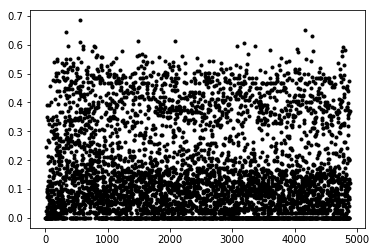

In [78]:
plt.plot(X,Y,'k.')

In [79]:
Q[3001]

0.16216216216216217

In [80]:
Y[3001]

0.0

In [81]:
qD=pd.DataFrame(Y,index=X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9602e0690>]],
      dtype=object)

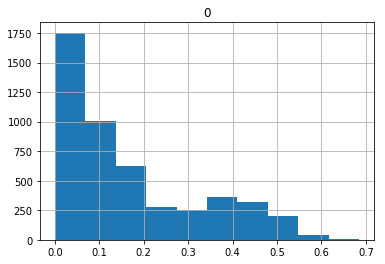

In [82]:
qD.hist()

In [83]:
P['P3000']

{'A': 0.00693069306930693,
 'C': 0.02079207920792079,
 'G': 0.00693069306930693,
 'T': 0.9653465346534653}

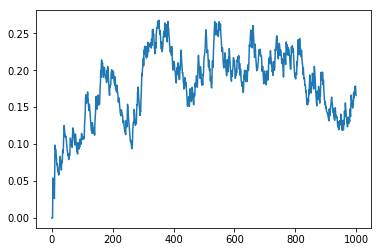

In [98]:

plt.plot(qD.ewm(com=20).mean().values[0:1000])

In [99]:
seq0=gn.loc[1]
seq1=gn.loc[20]
P0,Q0=getPerturbation(seq0,PATH_TO_TREES)
P1,Q1=getPerturbation(seq1,PATH_TO_TREES)

100%|██████████| 4842/4842 [00:01<00:00, 3510.46it/s]


In [101]:
def getDistance(seq0,seq1,PATH_TO_TREES):
    P0,Q0=getPerturbation(seq0,PATH_TO_TREES)
    P1,Q1=getPerturbation(seq1,PATH_TO_TREES)
    S=0.0
    for key in P0.keys():
        
        A=[]
        B=[]
        for key0,value0 in P0[key].iteritems():
            A=np.append(A,value0)
            B=np.append(B,P1[key][key0])
            
        S=S+np.max(np.abs(A-B))    
         
    return S/(0.0+len(P0.keys()))      
            

In [105]:
getDistance(seq1,gn.loc[69],PATH_TO_TREES)

100%|██████████| 4842/4842 [00:01<00:00, 3123.46it/s]


0.40262786059858385

In [104]:
gn.index.size

71

In [106]:
getDistance(seq1,gn.loc[69],PATH_TO_TREES)

100%|██████████| 4842/4842 [00:01<00:00, 3509.53it/s]


0.05979256347294066